In [ ]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy.stats import uniform
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor,plot_tree, ExtraTreeClassifier
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor,AdaBoostRegressor,RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error,classification_report
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
from matplotlib import colors
from matplotlib.patches import Patch
from matplotlib.artist import Artist


sns.set()
inciso_asociado=['Inciso B (único árbol para clasificación de High)', 
                 'Inciso G (random forest para clasificación de High)',
                 'Inciso C (único árbol para regresión de Sales)',
                 'Inciso E (único árbol con CV para regresión de Sales)',
                 'Inciso F (bagging para regresión de Sales)',
                 'Inciso G (random forest para regresión de Sales)',
                 'Inciso H (AdaBoost para regresión de Sales)',
                 ]

#Cargo y preproceso la base de datos
carseats_df = pd.read_csv("Carseats.csv")
carseats_df["ShelveLoc"] = pd.factorize(carseats_df["ShelveLoc"])[0]
carseats_df["Urban"] = pd.factorize(carseats_df["Urban"])[0]
carseats_df["US"] = pd.factorize(carseats_df["US"])[0]
carseats_df["High"] = carseats_df["Sales"].map(lambda x: 'No' if x <= 8 else 'Yes')
collist = [x for x in carseats_df.columns if x not in ('Sales', 'High')]
X = carseats_df[collist].values
y = pd.factorize(carseats_df["High"])[0]
y_s = carseats_df["Sales"].values

#Inciso a
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y_s, test_size=0.25)

In [ ]:
#Algunas funciones útiles

def my_plot_tree(model,name,titulo,plot_depth=None,size=(9,6)): #name tiene la forma 'name.pdf'
  fig = plt.figure(figsize=size)
  plt.tight_layout()
  plot_tree(model, filled=True, max_depth=plot_depth,fontsize=8,rounded=True,
            precision=1)
  plt.title(titulo)
  plt.savefig(name, format='pdf')
  plt.show()

def my_roc_plot(fpr,tpr,fpr_test,tpr_test,name):
  fig = plt.figure(figsize=(9,6))
  plt.plot(fpr, tpr, label='Training')
  plt.plot(fpr_test, tpr_test, label='Test')
  plt.title('ROC curve', fontsize=16)
  plt.xlabel('False positive ratio', fontsize=14)
  plt.ylabel('True positive ratio')
  plt.legend(fontsize=14)
  plt.tight_layout()
  plt.savefig(name, format='pdf')
  plt.show()

def my_classification_eval(model,X_train,y_train,X_test,y_test):
  y_scores=model.predict_proba(X_train) 
  fpr, tpr, thresholds = roc_curve(y_train, y_scores[:, 1])
  print('AUC training ', roc_auc_score(y_train, y_scores[:, 1]))
  y_scores_test=model.predict_proba(X_test) 
  fpr_test, tpr_test, thresholds = roc_curve(y_test, y_scores_test[:, 1])
  print('AUC test', roc_auc_score(y_test, y_scores_test[:, 1]))
  return fpr, tpr, fpr_test, tpr_test

def my_regression_eval(reg,X_train_s,y_train_s,X_test_s,y_test_s,name):
  preds_val = reg.predict(X_test_s)
  plt.scatter(preds_val,y_test_s)
  x=np.linspace(0,np.amax(y_train_s),100)
  preds_val_train = reg.predict(X_train_s)
  plt.scatter(preds_val_train, y_train_s, label='Training')
  plt.scatter(preds_val, y_test_s, label='Test')
  plt.plot(x,x,label='Identidad')
  plt.xlabel('Predicciones', fontsize=14)
  plt.ylabel('Valores reales')
  plt.legend(fontsize=14)
  plt.tight_layout()
  plt.savefig(name, format='pdf')
  plt.show()

def my_easy_cv(model,x,y):
  param_grid= [{'max_depth': np.arange(2,20,1), 
                  'ccp_alpha': model.cost_complexity_pruning_path(x,y).ccp_alphas
                  }]
  return RandomizedSearchCV(model,param_grid, cv=5, n_iter=1000,
                            scoring='neg_mean_squared_error',
                            return_train_score=True)

def my_overfit_metric(a,b): #Cuantifico el overfitting por la diferencia entre los errores de test y train sobre el promedio de ambos (*100)
  return 100*(a-b)/(a+b)

def normalize_df(data,name,n):
  norm=data[name].sum(axis = 0, skipna = True) 
  data[name]=(data[name]/norm)*n
  return data
def organize_df(tester,):
  tester=tester.assign(new=tester.groupby(level=0).cumcount()+1)
  s=tester.reset_index().pivot(index='Atributo',columns='new',values='Importancias').add_prefix('modelo')
  return s

def my_importances_display(models,collist,names,title,num=0.2 ,data=None,verbose=0,save_name='sin_nombre.pdf'):
  fig, ax = plt.subplots(figsize=(12, 4))
  dffs=pd.DataFrame()
  for i in range(len(names)):
    imp = permutation_importance(models[i],data[0], data[1],n_repeats=30,random_state=0)
    importance = imp.importances_mean
    if verbose!=0:
      for j,v in enumerate(importance):
        print('Característica {a} : Score = {b}'.format(a=collist[j],b=v))
    df = pd.DataFrame({"Importancias":importance,
                  "Atributo":collist},index=collist)
    dff=normalize_df(df,'Importancias',100)
    dffs=dffs.append(dff)

  data=organize_df(dffs).sort_values(by='modelo{}'.format(len(names)-1))
  clases=list(data.index)
  p_importancias=np.transpose(data.values)
  x=np.arange(1,11,1)
  for i in range(len(models)):
    plt.bar(x+num*(i-1),p_importancias[i],width=num,alpha=0.7,label=names[i])
  plt.ylabel('Porcentaje de importancia (%)')
  plt.xticks(x, clases, fontsize=12)
  plt.title(title)
  plt.ylim(bottom=0)
  plt.legend()
  plt.tight_layout()
  plt.savefig(save_name, format='pdf')
  plt.show()
 


def display_results(mse_test_general,inciso_asociado):
  for idx in range(len(mse_test_general)):
    if idx==2: print('=========================================================================')
    print("{i}: MSE con test:{test:.3} \n".format(i = inciso_asociado[idx], 
                                                  test =mse_test_general[idx]))
                                                  

def my_hp_plot(hp_type,hp,name,X_train_s,X_test_s,y_train_s,y_test_s):
  mse_g_test_p=np.zeros(len(hp))
  mse_g_train_p=np.zeros(len(hp))
  for p in hp:
    if hp_type=='max_features':
      rf=RandomForestRegressor(max_features=(p+1)).fit(X_train_s, y_train_s)
      mse_g_test_p[p] = mean_squared_error(y_test_s,rf.predict(X_test_s))
      mse_g_train_p[p] = mean_squared_error(y_train_s,rf.predict(X_train_s))
    elif hp_type=='max_depth':
      rf=RandomForestRegressor(max_depth=(p+1)).fit(X_train_s, y_train_s)
      mse_g_test_p[p] = mean_squared_error(y_test_s,rf.predict(X_test_s))
      mse_g_train_p[p] = mean_squared_error(y_train_s,rf.predict(X_train_s))
    else:
      print('Hiperparámetro no disponible, puedes elegir entre: max_features y max_depth')
      return
  fig,ax=plt.subplots()
  x=np.linspace(1,len(hp),len(hp))
  ax.scatter(x,mse_g_test_p,label='Test')
  ax.scatter(x,mse_g_train_p,label='Train')
  plt.xlabel('Variación del hiperparámetro {}'.format(hp_type))
  plt.ylabel('MSE')
  plt.tight_layout()
  plt.legend()
  plt.savefig(name, format='pdf')
  plt.show()


AUC training  1.0
AUC test 0.7250000000000001


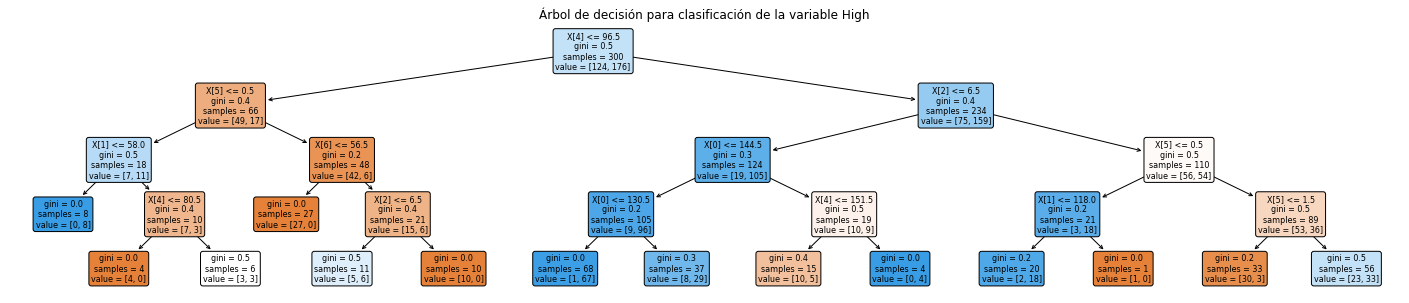

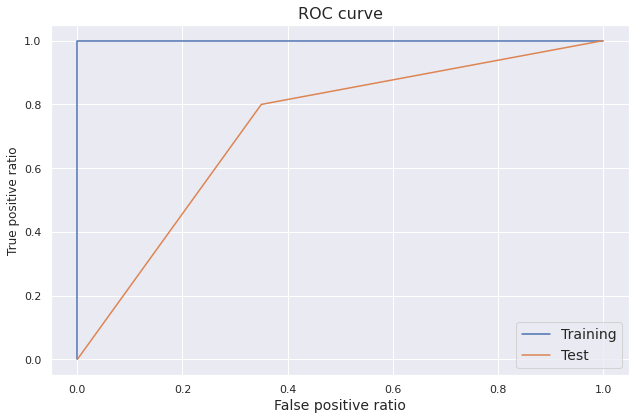

In [ ]:
#Inciso b
clf_plot = DecisionTreeClassifier(max_depth=4).fit(X_train,y_train) #Solo para el ploteo del árbol
clf = DecisionTreeClassifier() #Para la clasificacion reportada
clf.fit(X_train,y_train)
fpr, tpr, fpr_test, tpr_test=my_classification_eval(clf,X_train,y_train,X_test,y_test)
sns.reset_orig()
my_plot_tree(clf_plot,'incisob_completo.pdf','Árbol de decisión para clasificación de la variable High',size=(25,5))
sns.set()
my_roc_plot(fpr, tpr, fpr_test, tpr_test,'incisob_roc.pdf')

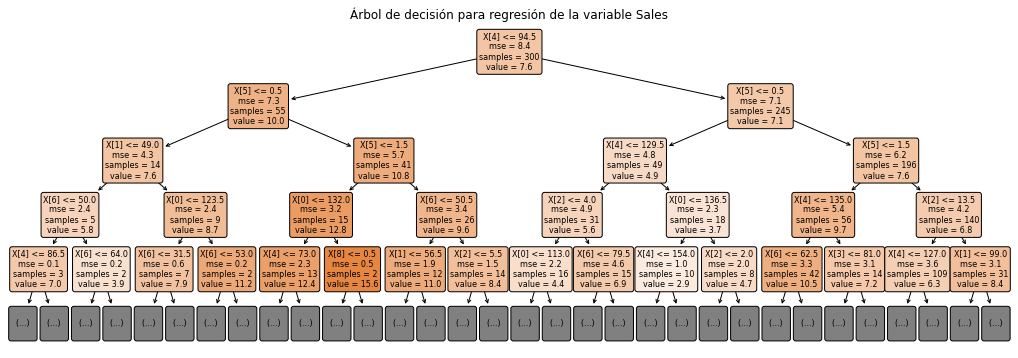

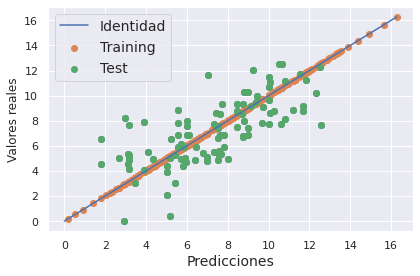

In [ ]:
#Inciso c
reg=DecisionTreeRegressor()
reg.fit(X_train_s,y_train_s)
sns.reset_orig()
my_plot_tree(reg,'incisoc.pdf','Árbol de decisión para regresión de la variable Sales',plot_depth=4,size=(18,6))
sns.set()
my_regression_eval(reg,X_train_s,y_train_s,X_test_s,y_test_s,'incisoc_res.pdf')

In [ ]:
#Inciso d
mse_b_train = mean_squared_error(y_train,clf.predict(X_train))
mse_b_test = mean_squared_error(y_test,clf.predict(X_test))
mse_c_train = mean_squared_error(y_train_s,reg.predict(X_train_s))
mse_c_test = mean_squared_error(y_test_s,reg.predict(X_test_s))

print('MSE para el inciso b (árbol de decisión para clasificación de la variable High):\n')
print("MSE con train: {train:.2f} \t  MSE con test:{test:.2f} \n".format(train = mse_b_train, test =mse_b_test))
print('MSE para el inciso c (árbol de decisión para regresión de la variable Sales):\n')
print("MSE con train: {train:.2f} \t  MSE con test:{test:.2f} \n".format(train = mse_c_train, test =mse_c_test))
print('Ambos modelos presentan overfitting')
overfit_perc=my_overfit_metric(mse_c_test,mse_b_test)
print("La diferencia entre el error de train y test es {:.2f} % mayor con el modelo de regresión".format(overfit_perc))

MSE para el inciso b (árbol de decisión para clasificación de la variable High):

MSE con train: 0.00 	  MSE con test:0.26 

MSE para el inciso c (árbol de decisión para regresión de la variable Sales):

MSE con train: 0.00 	  MSE con test:3.99 

Ambos modelos presentan overfitting
La diferencia entre el error de train y test es 87.77 % mayor con el modelo de regresión


In [ ]:
#Inciso e
randm_search=my_easy_cv(DecisionTreeRegressor(),X_train_s,y_train_s).fit(X_train_s,y_train_s)

print('Mejores parámetros:{}'.format(randm_search.best_params_))
final_model=randm_search.best_estimator_.fit(X_train_s,y_train_s)
mse_e_train = mean_squared_error(y_train_s,final_model.predict(X_train_s))
mse_e_test = mean_squared_error(y_test_s,final_model.predict(X_test_s))

print('MSE para el inciso e (árbol de decisión para regresión de la variable Sales usando cross-validation y pruning):')
print("MSE con train: {train} \t  MSE con test:{test} \n".format(train = mse_e_train, test =mse_e_test))
overfit_c=my_overfit_metric(mse_c_test,mse_c_train)
overfit_e=my_overfit_metric(mse_e_test,mse_e_train)
print("El porcentaje de overfitting conseguido en el inciso c es {:.2f} % ".format(overfit_c))
print("El porcentaje de overfitting conseguido en el inciso e es {:.2f} % ".format(overfit_e))
print("Redujimos el overfitting en un factor de aproximadamente {:.2f}".format(overfit_c/overfit_e))


Mejores parámetros:{'max_depth': 14, 'ccp_alpha': 0.03645637692307281}
MSE para el inciso e (árbol de decisión para regresión de la variable Sales usando cross-validation y pruning):
MSE con train: 1.2700075938514457 	  MSE con test:3.7649690688306405 

El porcentaje de overfitting conseguido en el inciso c es 100.00 % 
El porcentaje de overfitting conseguido en el inciso e es 49.55 % 
Redujimos el overfitting en un factor de aproximadamente 2.02


MSE para el inciso f (abordaje tipo bagging):
MSE con train: 0.43876144 	  MSE con test:2.3875637000000003 

El porcentaje de overfitting conseguido en el inciso c (único árbol) es 100.00 % 
El porcentaje de overfitting conseguido en el inciso e es 49.55 % 
El porcentaje de overfitting conseguido en el inciso f es 68.95 % 
Redujimos el overfitting en un factor de aproximadamente respecto a un único árbol 1.45
Redujimos el overfitting en un factor de aproximadamente respecto del modelo sin bagging 0.72




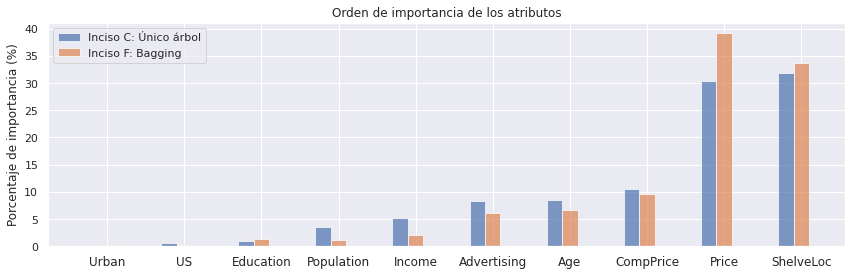

In [ ]:
#Inciso f
bag=BaggingRegressor(DecisionTreeRegressor()).fit(X_train_s, y_train_s)
mse_f_train = mean_squared_error(y_train_s,bag.predict(X_train_s))
mse_f_test = mean_squared_error(y_test_s,bag.predict(X_test_s))
print('MSE para el inciso f (abordaje tipo bagging):')
print("MSE con train: {train} \t  MSE con test:{test} \n".format(train = mse_f_train, test =mse_f_test))
overfit_f=my_overfit_metric(mse_f_test,mse_f_train)

print("El porcentaje de overfitting conseguido en el inciso c (único árbol) es {:.2f} % ".format(overfit_c))
print("El porcentaje de overfitting conseguido en el inciso e es {:.2f} % ".format(overfit_e))
print("El porcentaje de overfitting conseguido en el inciso f es {:.2f} % ".format(overfit_f))
print("Redujimos el overfitting en un factor de aproximadamente respecto a un único árbol {:.2f}".format(overfit_c/overfit_f))
print("Redujimos el overfitting en un factor de aproximadamente respecto del modelo sin bagging {:.2f}".format(overfit_e/overfit_f))
print('\n')

tit='Orden de importancia de los atributos'
lab=['Inciso C: Único árbol','Inciso F: Bagging']
models=[reg,bag]

my_importances_display(models,collist,lab,tit,data=[X_train_s,y_train_s],num=0.2,verbose=0,save_name='incisof.pdf')

                     

Overfitting:67.00520024629216
Inciso B (único árbol para clasificación de High): MSE con test:0.26 

Inciso G (random forest para clasificación de High): MSE con test:0.2 

Inciso C (único árbol para regresión de Sales): MSE con test:3.99 

Inciso E (único árbol con CV para regresión de Sales): MSE con test:3.76 

Inciso F (bagging para regresión de Sales): MSE con test:2.39 

Inciso G (random forest para regresión de Sales): MSE con test:1.92 



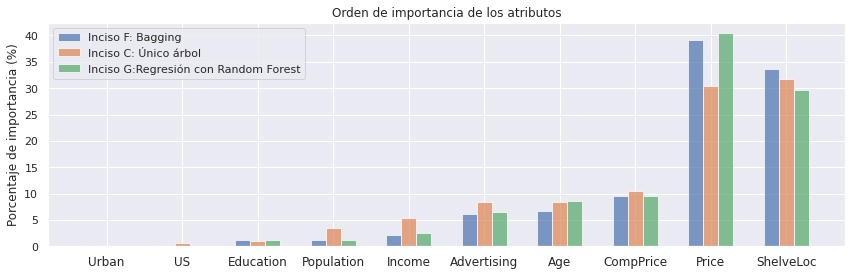

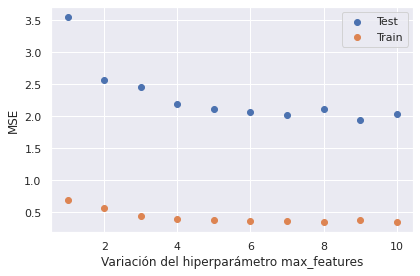

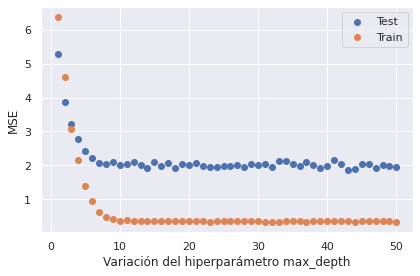

In [ ]:
#Inciso g
rf=RandomForestRegressor().fit(X_train_s, y_train_s)
mse_g_test = mean_squared_error(y_test_s,rf.predict(X_test_s))
mse_g_train = mean_squared_error(y_train_s,rf.predict(X_train_s))
print('Overfitting:{}'.format(my_overfit_metric(mse_g_test,mse_g_train)))
rf_c=RandomForestClassifier().fit(X_train, y_train)
mse_g_test_c = mean_squared_error(y_test,rf_c.predict(X_test))
mse_test_general=[mse_b_test,mse_g_test_c, mse_c_test,mse_e_test, mse_f_test,mse_g_test]
display_results(mse_test_general,inciso_asociado)


lab=['Inciso F: Bagging','Inciso C: Único árbol','Inciso G:Regresión con Random Forest']
models=[bag,reg,rf]
bools=[True,False,False]
my_importances_display(models,collist,lab,tit,data=[X_train_s,y_train_s],num=0.2,verbose=0,save_name='incisog.pdf')


#Plot error de test en función del del hiperparámetro max_features y max_depth
hp=np.arange(0,10,1)
my_hp_plot('max_features',hp,'incisog_mf.pdf',X_train_s,X_test_s,y_train_s,y_test_s)
hp=np.arange(0,50,1)
my_hp_plot('max_depth',hp,'incisog_md.pdf',X_train_s,X_test_s,y_train_s,y_test_s)


20.000605316559625


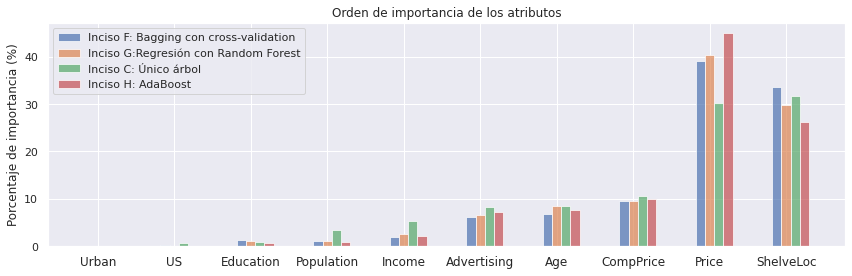

Hay cambio en el orden de importancias de los atributos con AdaBoost :O
Inciso B (único árbol para clasificación de High): MSE con test:0.26 

Inciso G (random forest para clasificación de High): MSE con test:0.2 

Inciso C (único árbol para regresión de Sales): MSE con test:3.99 

Inciso E (único árbol con CV para regresión de Sales): MSE con test:3.76 

Inciso F (bagging para regresión de Sales): MSE con test:2.39 

Inciso G (random forest para regresión de Sales): MSE con test:1.92 

Inciso H (AdaBoost para regresión de Sales): MSE con test:2.45 



In [ ]:
#Inciso h
ada= AdaBoostRegressor()
ada.fit(X_train_s, y_train_s)
mse_h_test_ada = mean_squared_error(y_test_s,ada.predict(X_test_s))
mse_h_train = mean_squared_error(y_train_s,ada.predict(X_train_s))
print(my_overfit_metric(mse_h_test_ada,mse_h_train))

lab=['Inciso F: Bagging con cross-validation',
     'Inciso G:Regresión con Random Forest',
     'Inciso C: Único árbol',
     'Inciso H: AdaBoost']
models=[bag,rf,reg,ada]

my_importances_display(models,collist,lab,tit,data=[X_train_s,y_train_s],num=0.12,verbose=0,save_name='incisoh.pdf')
print('Hay cambio en el orden de importancias de los atributos con AdaBoost :O')
mse_test_general.append(mse_h_test_ada)
display_results(mse_test_general,inciso_asociado)